Installing Keras-Tuner

In [1]:

!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


Connecting to the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing the modules required

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetB0, InceptionV3, ResNet50, DenseNet121, VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt

<ipython-input-3-6bfedc0b9050>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Load and preprocess of images

In [4]:
# Data Preprocessing
def preprocess_input(img):
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            img = preprocess_input(img)
            img = np.stack((img,)*3, axis=-1)  # Convert grayscale to RGB by stacking
            if img is not None:
                images.append(img)
    return np.array(images)




# Load datasets
train_normal = load_images_from_folder('/content/drive/MyDrive/ct_images_02/DATASET/train/train/normal')
train_tumor = load_images_from_folder('/content/drive/MyDrive/ct_images_02/DATASET/train/train/pancreatic_tumor')
test_normal = load_images_from_folder('/content/drive/MyDrive/ct_images_02/DATASET/test/test/normal')
test_tumor = load_images_from_folder('/content/drive/MyDrive/ct_images_02/DATASET/test/test/pancreatic_tumor')

Labeling

In [6]:
# Create labels
train_labels_normal = np.zeros(train_normal.shape[0])
train_labels_tumor = np.ones(train_tumor.shape[0])
test_labels_normal = np.zeros(test_normal.shape[0])
test_labels_tumor = np.ones(test_tumor.shape[0])

# Combine datasets
train_images = np.concatenate((train_normal, train_tumor), axis=0)
train_labels = np.concatenate((train_labels_normal, train_labels_tumor), axis=0)
test_images = np.concatenate((test_normal, test_tumor), axis=0)
test_labels = np.concatenate((test_labels_normal, test_labels_tumor), axis=0)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Apply augmentation to training images
train_images = data_augmentation(train_images, training=True)


Declaring Best hyperparameter

In [5]:
# Set the best learning rate obtained from previous tuning
best_learning_rate = 0.0001

Defining the function for model evaluation

In [7]:
# Evaluate the Models
def evaluate_model(model, test_images, test_labels):
    # Make predictions
    y_pred = (model.predict([test_images, test_images]) > 0.5).astype("int32")

    # Generate confusion matrix
    confusion_mtx = confusion_matrix(test_labels, y_pred)

    TN, FP, FN, TP = confusion_mtx.ravel()

    # Calculate metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    return accuracy, precision, recall, f1_score, specificity, confusion_mtx




Definining the VGG16V2 model

In [12]:
def VGG16V2():
    base_model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D()(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)

    combined = Concatenate()([x1, x2])
    x = Dense(256, activation='relu')(combined)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model

Training the VGG16V2 Model

In [ ]:
# Train Hybrid Model VGG16V2
model1 = VGG16V2()
model1.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model1.fit([train_images, train_images], train_labels, validation_split=0.25, epochs=10)


Epoch 1/10
24/24 [==============================] - 125s 5s/step - loss: 0.1534 - accuracy: 0.9398 - val_loss: 0.0672 - val_accuracy: 0.9680
Epoch 2/10
24/24 [==============================] - 110s 5s/step - loss: 0.0392 - accuracy: 0.9813 - val_loss: 1.5865 - val_accuracy: 0.2280
Epoch 3/10
24/24 [==============================] - 110s 5s/step - loss: 0.0171 - accuracy: 0.9973 - val_loss: 0.1100 - val_accuracy: 0.9360
Epoch 4/10
24/24 [==============================] - 109s 5s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.1511 - val_accuracy: 0.9200
Epoch 5/10
24/24 [==============================] - 109s 5s/step - loss: 0.0049 - accuracy: 0.9973 - val_loss: 0.6052 - val_accuracy: 0.8040
Epoch 6/10
24/24 [==============================] - 109s 5s/step - loss: 0.0101 - accuracy: 0.9960 - val_loss: 0.8956 - val_accuracy: 0.7200
Epoch 7/10
24/24 [==============================] - 109s 5s/step - loss: 0.0129 - accuracy: 0.9960 - val_loss: 0.1980 - val_accuracy: 0.9080
Epoch 8/10
24

Evaluating the VGG16V2 Model

In [ ]:
# Evaluate Hybrid Model 1
metrics1 = evaluate_model(model1, test_images, test_labels)
print(f"Hybrid Model 1 (EfficientNetB0 + InceptionV3): Accuracy: {metrics1[0]:.4f}, Precision: {metrics1[1]:.4f}, Recall: {metrics1[2]:.4f}, F1 Score: {metrics1[3]:.4f}, Specificity: {metrics1[4]:.4f}")


Definining the EfficientDense model

In [ ]:
def EfficientDense():
    base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D(name='efficientnet_pooling')(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D(name='densenet_pooling')(x2)

    combined = Concatenate(name='concatenate')([x1, x2])
    x = Dense(256, activation='relu', name='dense1')(combined)
    predictions = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model


Training the EfficientDense Model

In [ ]:
# Train Hybrid Model EfficientDense
model2 = EfficientDense()
model2.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model2.fit([train_images, train_images], train_labels, validation_split=0.2, epochs=10)


Epoch 1/10
25/25 [==============================] - 145s 4s/step - loss: 0.1528 - accuracy: 0.9361 - val_loss: 0.2321 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 88s 4s/step - loss: 0.0408 - accuracy: 0.9875 - val_loss: 0.6073 - val_accuracy: 0.6750
Epoch 3/10
25/25 [==============================] - 88s 4s/step - loss: 0.0189 - accuracy: 0.9962 - val_loss: 0.4794 - val_accuracy: 0.8150
Epoch 4/10
25/25 [==============================] - 87s 3s/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.6498 - val_accuracy: 0.6300
Epoch 5/10
25/25 [==============================] - 86s 3s/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.5424 - val_accuracy: 0.7500
Epoch 6/10
25/25 [==============================] - 86s 3s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.4057 - val_accuracy: 0.8650
Epoch 7/10
25/25 [==============================] - 84s 3s/step - loss: 7.2626e-04 - accuracy: 1.0000 - val_loss: 0.2872 - val_accuracy: 0.9400
Epoch 8/10
25/2

Evaluating the EfficientDense Model

In [ ]:
# Evaluate Hybrid Model 2
metrics2 = evaluate_model(model2, test_images, test_labels)
print(f"Hybrid Model 2 (ResNet50 + DenseNet121): Accuracy: {metrics2[0]:.4f}, Precision: {metrics2[1]:.4f}, Recall: {metrics2[2]:.4f}, F1 Score: {metrics2[3]:.4f}, Specificity: {metrics2[4]:.4f}")


13/13 [==============================] - 11s 584ms/step
Hybrid Model 2 (ResNet50 + DenseNet121): Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Specificity: 1.0000


Definining the EfficientV3 model

In [ ]:
# Define Hybrid Models

def EfficientV3():
    base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D()(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)

    combined = Concatenate()([x1, x2])
    x = Dense(256, activation='relu')(combined)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model

Training the EfficientV3 Model

In [ ]:
# Train Hybrid Model EfficientV3
model3 = EfficientV3()
model3.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model3.fit([train_images, train_images], train_labels, validation_split=0.2, epochs=10)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/10
25/25 [==============================] - 90s 2s/step - loss: 0.1715 - accuracy: 0.9461 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 46s 2s/step - loss: 0.0344 - accuracy: 0.9862 - val_loss: 1.4519e-04 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 45s 2s/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0068 - val_accuracy: 0.9950
Epoch 4/10
25/25 [==============================] - 45s 2s/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 0.0292 - val_accuracy: 0.9900
Epoch 5/10
25/25 [==============================] - 45s 2s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 6/10
25/25 [==============================] - 44s 2s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 44s 2s/step - loss: 7.7850e-04 - accura

Evaluating the EfficientV3 Model

In [ ]:
# Evaluate Hybrid Model 3
metrics3 = evaluate_model(model3, test_images, test_labels)
print(f"Hybrid Model 3 (VGG16 + MobileNetV2): Accuracy: {metrics3[0]:.4f}, Precision: {metrics3[1]:.4f}, Recall: {metrics3[2]:.4f}, F1 Score: {metrics3[3]:.4f}, Specificity: {metrics3[4]:.4f}")


13/13 [==============================] - 7s 328ms/step
Hybrid Model 3 (VGG16 + MobileNetV2): Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000, Specificity: 1.0000


Definining the InceptionDense model

In [ ]:
def InceptionDense():
    base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D(name='inception_pooling')(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D(name='densenet_pooling')(x2)

    combined = Concatenate(name='concatenate')( [x1, x2])
    x = Dense(256, activation='relu', name='dense1')(combined)
    predictions = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model

Training the InceptionDense Model

In [ ]:
# Train Hybrid Model InceptionDense
model4 = InceptionDense()
model4.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model4.fit([train_images, train_images], train_labels, validation_split=0.2, epochs=10)

Epoch 1/10
25/25 [==============================] - 136s 3s/step - loss: 0.1741 - accuracy: 0.9386 - val_loss: 0.0697 - val_accuracy: 0.9750
Epoch 2/10
25/25 [==============================] - 80s 3s/step - loss: 0.0311 - accuracy: 0.9887 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 80s 3s/step - loss: 0.0140 - accuracy: 0.9950 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 80s 3s/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9950
Epoch 5/10
25/25 [==============================] - 80s 3s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9900
Epoch 6/10
25/25 [==============================] - 80s 3s/step - loss: 5.1583e-04 - accuracy: 1.0000 - val_loss: 0.0351 - val_accuracy: 0.9900
Epoch 7/10
25/25 [==============================] - 81s 3s/step - loss: 2.2286e-04 - accuracy: 1.0000 - val_loss: 0.0367 - val_accuracy: 0.9850
Epoch 8/10


Evaluating the InceptionDense Model

In [ ]:

# Evaluate Hybrid Model 4
metrics4 = evaluate_model(model4, test_images, test_labels)
print(f"Hybrid Model 4 (InceptionV3 + DenseNet121): Accuracy: {metrics4[0]:.4f}, Precision: {metrics4[1]:.4f}, Recall: {metrics4[2]:.4f}, F1 Score: {metrics4[3]:.4f}, Specificity: {metrics4[4]:.4f}")


13/13 [==============================] - 11s 564ms/step
Hybrid Model 4 (InceptionV3 + DenseNet121): Accuracy: 0.9975, Precision: 0.9947, Recall: 1.0000, F1 Score: 0.9973, Specificity: 0.9952


Definining the EfficientVGG model

In [ ]:
def EfficientVGG():
    base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D(name='efficientnet_pooling')(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D(name='vgg_pooling')(x2)

    combined = Concatenate(name='concatenate')( [x1, x2])
    x = Dense(256, activation='relu', name='dense1')(combined)
    predictions = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model

Training the EfficientVGG Model

In [ ]:
# Train Hybrid Model EfficientVGG
model5 = EfficientVGG()
model5.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model5.fit([train_images, train_images], train_labels, validation_split=0.2, epochs=10)

Epoch 1/10
25/25 [==============================] - 151s 5s/step - loss: 0.1800 - accuracy: 0.9361 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 127s 5s/step - loss: 0.0593 - accuracy: 0.9737 - val_loss: 3.1360e-07 - val_accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 126s 5s/step - loss: 0.0388 - accuracy: 0.9850 - val_loss: 7.1271e-06 - val_accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 126s 5s/step - loss: 0.0303 - accuracy: 0.9912 - val_loss: 1.6909e-05 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 125s 5s/step - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0358 - val_accuracy: 0.9950
Epoch 6/10
25/25 [==============================] - 125s 5s/step - loss: 0.0081 - accuracy: 0.9975 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 125s 5s/step - loss: 0.0081 - accuracy: 0.9987 - val_loss: 2.4053e-04 - val_accuracy: 1.00

Evaluating the EfficientVGG Model

In [ ]:
# Evaluate Hybrid Model 5
metrics5 = evaluate_model(model5, test_images, test_labels)
print(f"Hybrid Model 5 (EfficientNetB0 + VGG16): Accuracy: {metrics5[0]:.4f}, Precision: {metrics5[1]:.4f}, Recall: {metrics5[2]:.4f}, F1 Score: {metrics5[3]:.4f}, Specificity: {metrics5[4]:.4f}")


13/13 [==============================] - 11s 704ms/step
Hybrid Model 5 (EfficientNetB0 + VGG16): Accuracy: 0.9975, Precision: 0.9947, Recall: 1.0000, F1 Score: 0.9973, Specificity: 0.9952


Definining the ResNetV2 model

In [8]:
def ResNetV2():
    base_model1 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x1 = base_model1.output
    x1 = GlobalAveragePooling2D(name='resnet_pooling')(x1)

    x2 = base_model2.output
    x2 = GlobalAveragePooling2D(name='mobilenet_pooling')(x2)

    combined = Concatenate(name='concatenate')( [x1, x2])
    x = Dense(256, activation='relu', name='dense1')(combined)
    predictions = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)
    return model

Training the ResNetV2 Model

In [9]:

# Train Hybrid Model ResNetV2
model6 = ResNetV2()
model6.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model6.fit([train_images, train_images], train_labels, validation_split=0.2, epochs=10)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
25/25 [==============================] - 92s 3s/step - loss: 0.1366 - accuracy: 0.9449 - val_loss: 0.0610 - val_accuracy: 1.0000
Epoch 2/10
25/25 [==============================] - 60s 2s/step - loss: 0.0266 - accuracy: 0.9900 - val_loss: 0.0506 - val_accuracy: 0.9950
Epoch 3/10
25/25 [==============================] - 59s 2s/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9950
Epoch 4/10
25/25 [==============================] - 59s 2s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0176 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 59s 2s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9950
Epoch 6/10
25/25 [==============================] - 58s 2s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0720 - val_accuracy: 0.9950
Epoch 7/10
25/25 [==============================] - 57s 2s/step - loss: 4.1459e-04 - accuracy: 1.

Evaluating the ResNetV2 Model

In [11]:

#  Evaluate Hybrid Model 6
metrics6 = evaluate_model(model6, test_images, test_labels)
print(f"Hybrid Model 6 (ResNet50 + MobileNetV2): Accuracy: {metrics6[0]:.4f}, Precision: {metrics6[1]:.4f}, Recall: {metrics6[2]:.4f}, F1 Score: {metrics6[3]:.4f}, Specificity: {metrics6[4]:.4f}")



13/13 [==============================] - 7s 540ms/step
Hybrid Model 6 (ResNet50 + MobileNetV2): Accuracy: 0.6540, Precision: 0.5772, Recall: 1.0000, F1 Score: 0.7319, Specificity: 0.3445


Accuracy Curve

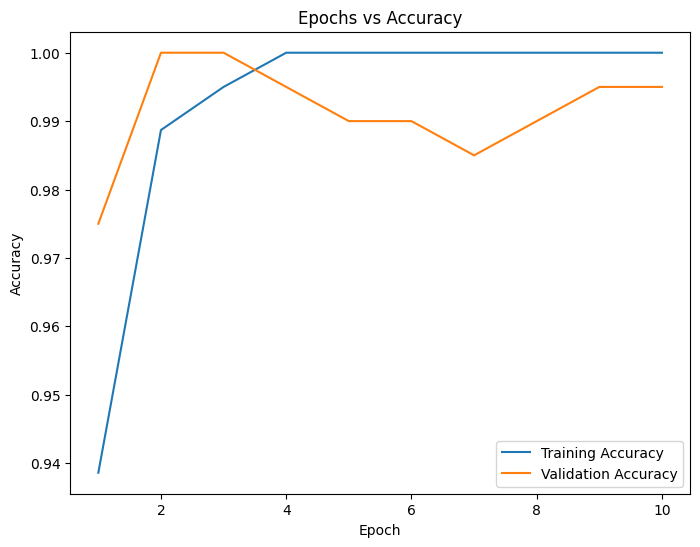

In [ ]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.9386, 0.9887, 0.995, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], label='Training Accuracy')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.975, 1.0, 1.0, 0.995, 0.99, 0.99, 0.985, 0.99, 0.995, 0.995], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epochs vs Accuracy')
plt.legend()
plt.show()


Loss Curve

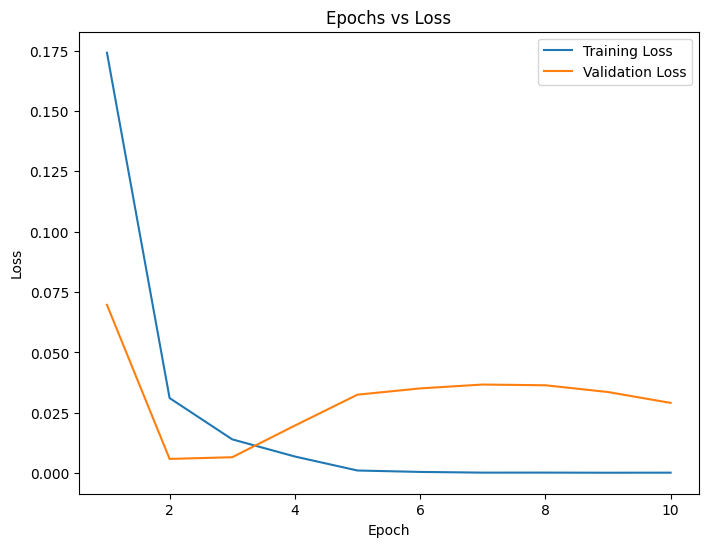

In [ ]:

# Loss graph
plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.1741, 0.0311, 0.014, 0.0069, 0.0011, 0.0005158, 0.0002229, 0.0002337, 0.0001841, 0.0002097], label='Training Loss')
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [0.0697, 0.0059, 0.0066, 0.0197, 0.0325, 0.0351, 0.0367, 0.0364, 0.0336, 0.0291], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.show()